In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

from datasets import load_dataset

import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

np.set_printoptions(precision=2)

# **Load Dataset**

In [2]:
ds = load_dataset("keremberke/chest-xray-classification", name="full")

In [3]:
X = ds['train']
y = ds['validation']

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})


# **Preprocess Data**

In [5]:
from PIL import Image
import numpy as np

# Define a function to resize, convert to grayscale, and flatten an image
def preprocess_image(image_path):
    # Open and resize the image to 20x20 pixels
    image = Image.open(image_path).resize((50, 50))
    # Convert to grayscale
    image = image.convert('L')
    # Flatten the image into a 400-dimensional vector
    image_array = np.array(image).flatten()
    return image_array

# Create empty arrays to store the data and labels
X_train = np.empty((4077, 2500), dtype=np.float32)
X_validation = np.empty((1165, 2500), dtype=np.float32)
X_test = np.empty((582, 2500), dtype=np.float32)

y_train = np.empty((4077,), dtype=np.int32)
y_validation = np.empty((1165,), dtype=np.int32)
y_test = np.empty((582,), dtype=np.int32)

# Iterate through your dataset, preprocess each image, and extract labels
for i, example in enumerate(ds['train']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_train[i] = image_array
    y_train[i] = example['labels']

for i, example in enumerate(ds['validation']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_validation[i] = image_array
    y_validation[i] = example['labels']

for i, example in enumerate(ds['test']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_test[i] = image_array
    y_test[i] = example['labels']

# Now, X_train, X_validation, and X_test contain the flattened 400-dimensional vectors of your images,
# and y_train, y_validation, and y_test contain the corresponding labels.


In [6]:
X_train[0]

array([ 28.,  62., 116., ...,  31.,  32.,  31.], dtype=float32)

In [7]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

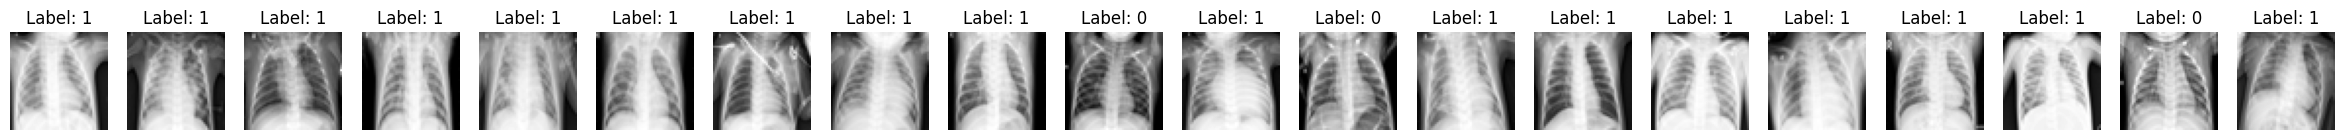

In [8]:
import random

# Define a function to visualize a random subset of the data
def visualize_random_data(images, labels, num_samples):
    num_total_samples = len(images)
    random_indices = random.sample(range(num_total_samples), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(30, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(50, 50), cmap='gray')
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of your training data
num_samples_to_visualize = 20
visualize_random_data(X_train, y_train, num_samples_to_visualize)


# **Neural Networks**

In [9]:
tf.random.set_seed(64)
model = Sequential(
    [
        tf.keras.Input(shape=(2500,)),
        Dense(256, activation='relu', name='L1'),
        Dense(150, activation='relu', name='L2'),
        Dense(64, activation='relu', name='L3'),
        Dense(32, activation='relu', name='L4'),
        Dense(16, activation='relu', name='L5'),
        Dense(2, activation='linear', name='L6')
    ], name = "my_model"
)

In [10]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 256)               640256    
                                                                 
 L2 (Dense)                  (None, 150)               38550     
                                                                 
 L3 (Dense)                  (None, 64)                9664      
                                                                 
 L4 (Dense)                  (None, 32)                2080      
                                                                 
 L5 (Dense)                  (None, 16)                528       
                                                                 
 L6 (Dense)                  (None, 2)                 34        
                                                                 
Total params: 691112 (2.64 MB)
Trainable params: 691112 (2

In [11]:
[layer1, layer2, layer3, layer4, layer5, layer6] = model.layers

In [12]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
W4,b4 = layer4.get_weights()
W5,b5 = layer5.get_weights()
W6,b6 = layer6.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")
print(f"W4 shape = {W4.shape}, b4 shape = {b4.shape}")
print(f"W5 shape = {W5.shape}, b5 shape = {b5.shape}")
print(f"W6 shape = {W6.shape}, b6 shape = {b6.shape}")

W1 shape = (2500, 256), b1 shape = (256,)
W2 shape = (256, 150), b2 shape = (150,)
W3 shape = (150, 64), b3 shape = (64,)
W4 shape = (64, 32), b4 shape = (32,)
W5 shape = (32, 16), b5 shape = (16,)
W6 shape = (16, 2), b6 shape = (2,)


In [13]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']  # Add accuracy as a metric for monitoring
)

# Train your model and store the training history
history = model.fit(
    X_train, y_train,
    epochs=500,
    validation_data=(X_validation, y_validation)  # Use validation data for monitoring
)

Epoch 1/500
128/128 [==============================] - 2s 9ms/step - loss: 12.0362 - accuracy: 0.7491 - val_loss: 2.0462 - val_accuracy: 0.8412
Epoch 2/500
128/128 [==============================] - 1s 9ms/step - loss: 2.7442 - accuracy: 0.8511 - val_loss: 2.8197 - val_accuracy: 0.8283
Epoch 3/500
128/128 [==============================] - 1s 8ms/step - loss: 1.2698 - accuracy: 0.8813 - val_loss: 0.4421 - val_accuracy: 0.9425
Epoch 4/500
128/128 [==============================] - 1s 8ms/step - loss: 1.3342 - accuracy: 0.8700 - val_loss: 0.9361 - val_accuracy: 0.9039
Epoch 5/500
128/128 [==============================] - 1s 8ms/step - loss: 1.7298 - accuracy: 0.8759 - val_loss: 2.7648 - val_accuracy: 0.7906
Epoch 6/500
128/128 [==============================] - 1s 7ms/step - loss: 0.8459 - accuracy: 0.8901 - val_loss: 0.2887 - val_accuracy: 0.9433
Epoch 7/500
128/128 [==============================] - 1s 7ms/step - loss: 0.3916 - accuracy: 0.9134 - val_loss: 0.3903 - val_accuracy: 0.879

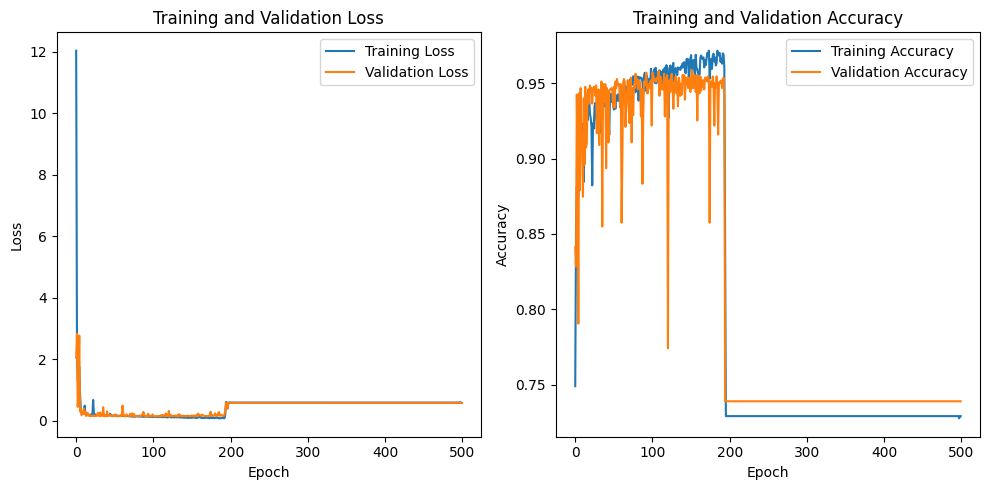

In [14]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



19/19 [==============================] - 0s 2ms/step


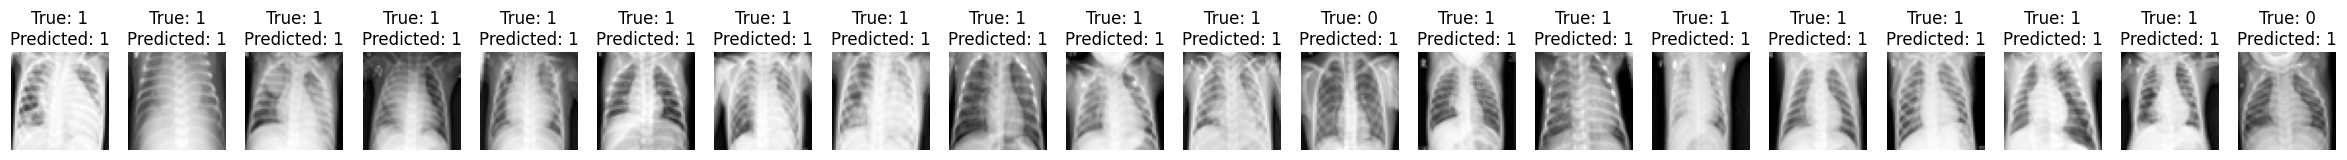

In [15]:
import matplotlib.pyplot as plt
import random

# Make predictions using your model on the test data
# Replace 'model' with the actual name of your trained model
predictions = model.predict(X_test)

# Define a function to visualize the results
def visualize_results(images, true_labels, predicted_labels, num_samples):
    random_indices = random.sample(range(len(images)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(30, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(50, 50), cmap='gray')
        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of test data along with their true and predicted labels
num_samples_to_visualize = 20
visualize_results(X_test, y_test, predictions.argmax(axis=1), num_samples_to_visualize)


19/19 [==============================] - 0s 2ms/step


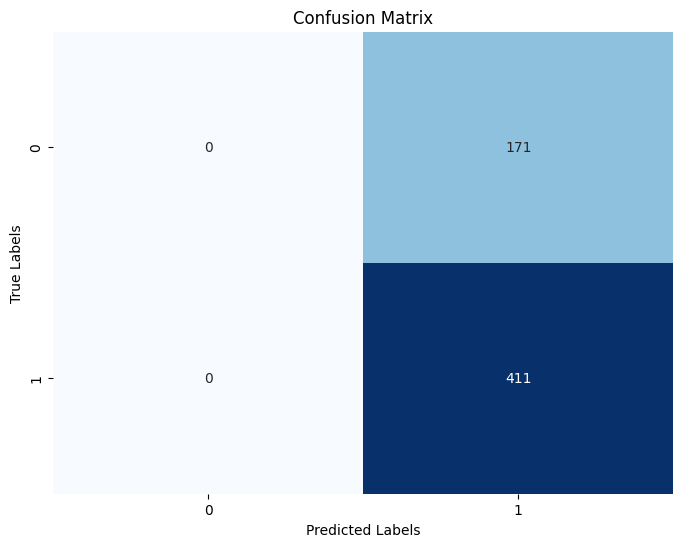

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
